In [1]:
import phasr as phr
import numpy as np
import matplotlib.pyplot as plt
from phasr.dirac_solvers.post_processing.overlap_integrals import nabla_dot, nabla_dot_plus, nabla_dot_minus
from phasr.physical_constants import masses
mmu=masses.mmu


In [2]:
AI_dict = phr.dirac_solvers.post_processing.correlation.prepare_results(Z=13,A=27,folder_path="./IMSRG_27Al/",name='Al27_ab_initio',r_cut=7)

Loaded datasets: ['1p82p0sim7p5', 'NIsample3448', 'EM2p02p0PWA', 'NIsample1173', 'NIsample0606', 'NIsample3472', '1p82p0EM7p5', 'NIsample3480', 'N2LOsat', 'NIsample4117', 'NIsample1802', 'NIsample2007', 'NIsample1141', 'EM2p22p0', 'NIsample0922', 'NIsample3260', 'NIsample3319', 'NIsample0500', 'NIsample3895', 'NIsample2245', 'NIsample0723', 'NIsample3621', 'NIsample1172', 'EM1p82p0', 'NIsample3098', 'NIsample3105', 'NIsample1177', 'EM2p02p0', 'NIsample2460', 'NIsample1469', 'NIsample0750', 'NIsample0090', 'NIsample2411', 'DN2LOGO', 'NIsample2125', 'NIsample3350']
data loaded from  ./tmp/nucleus_splines/charge_density_M0p_Al27_ab_initio_1p82p0sim7p5_x=0.0-7-0.05.txt
data loaded from  ./tmp/nucleus_splines/charge_density_laplace_M0p_Al27_ab_initio_1p82p0sim7p5_x=0.0-7.700000000000001-0.05.txt
data loaded from  ./tmp/nucleus_splines/charge_density_M0n_Al27_ab_initio_1p82p0sim7p5_x=0.0-7-0.05.txt
data loaded from  ./tmp/nucleus_splines/charge_density_laplace_M0n_Al27_ab_initio_1p82p0sim7p5

/home/thanos/anaconda3/envs/mu2e/lib/python3.9/site-packages/phasr/nuclei/parameterizations/numerical.py:355: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrali = quad(integrand,Rmin,Rmax,limit=1000)[0]


data loaded from  ./tmp/nucleus_splines/electric_field_Al27_ab_initio_NIsample3480_x=0.0-7-0.05.txt
data loaded from  ./tmp/nucleus_splines/electric_potential_Al27_ab_initio_NIsample3480_x=0.0-7-0.05.txt
Radii (NIsample3480) are consistent up to a level of at least: 2.7e-04
data loaded from  ./tmp/nucleus_splines/charge_density_M0p_Al27_ab_initio_N2LOsat_x=0.0-7-0.05.txt
data loaded from  ./tmp/nucleus_splines/charge_density_laplace_M0p_Al27_ab_initio_N2LOsat_x=0.0-7.700000000000001-0.05.txt
data loaded from  ./tmp/nucleus_splines/charge_density_M0n_Al27_ab_initio_N2LOsat_x=0.0-7-0.05.txt
data loaded from  ./tmp/nucleus_splines/charge_density_laplace_M0n_Al27_ab_initio_N2LOsat_x=0.0-7.700000000000001-0.05.txt
data loaded from  ./tmp/nucleus_splines/charge_density_Phipp0p_Al27_ab_initio_N2LOsat_x=0.0-7-0.05.txt
data loaded from  ./tmp/nucleus_splines/charge_density_laplace_Phipp0p_Al27_ab_initio_N2LOsat_x=0.0-7.700000000000001-0.05.txt
data loaded from  ./tmp/nucleus_splines/charge_dens

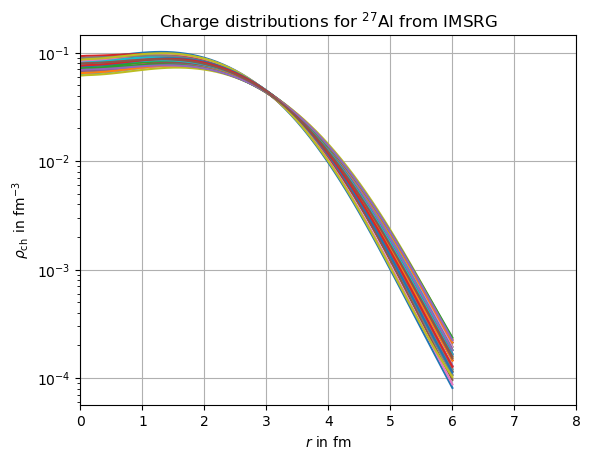

In [3]:

r=np.arange(0,6+0.1,0.1)
for key in AI_dict:
    key_nucleus = AI_dict[key]['atom']
    plt.plot(r,key_nucleus.charge_density(r))
plt.title('Charge distributions for $^{27}$Al from IMSRG')
plt.xlabel(r'$r$ in fm')
plt.ylabel(r'$\rho_{\operatorname{ch}}$ in fm$^{-3}$')
plt.grid()
plt.yscale('log')
plt.xlim(0,8)
plt.show()

Text(0, 0.5, 'Integrand value')

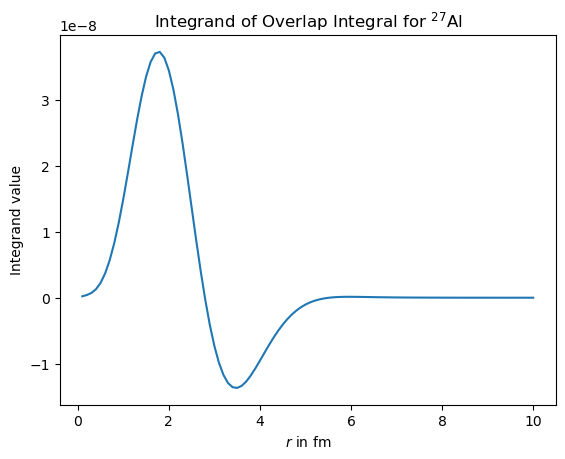

In [23]:
# Overlap integral

AI_model=list(AI_dict.keys())[1]
nucleus=AI_dict[AI_model]['atom']

# Calculate electron wavefunctions for ejected electron
AI_dict[AI_model]['ge_wavefunctions']={}
AI_dict[AI_model]['fe_wavefunctions']={}
for kappa in np.arange(-1,-2*nucleus.spin-2,-1,dtype=int):
    continuumstates = phr.continuumstates(nucleus,kappa=kappa,energy=mmu,verbose=False,potential_precision=1e-6)
    continuumstates.solve_IVP()
    AI_dict[AI_model]['ge_wavefunctions'][str(kappa)] = continuumstates.wavefct_g
    AI_dict[AI_model]['fe_wavefunctions'][str(kappa)] = continuumstates.wavefct_f

# Calculate muon wavefunctions for bound muon
AI_dict[AI_model]['gmu_wavefunctions']={}
AI_dict[AI_model]['fmu_wavefunctions']={}
boundstates = phr.boundstates(nucleus,kappa=-1,lepton_mass=mmu, verbose=False,potential_precision=1e-6)
AI_dict[AI_model]['gmu_wavefunction']=boundstates.wavefunction_g_1s12
AI_dict[AI_model]['fmu_wavefunction']=boundstates.wavefunction_f_1s12

def integrand(x):
    L=0
    hadronic= nabla_dot(x,nucleus.rhoPhipp0p,L)/mmu**2
    leptonic= AI_dict[AI_model]['ge_wavefunctions'][str(-(L+1))](x)*AI_dict[AI_model]['gmu_wavefunction'](x) - \
                AI_dict[AI_model]['fe_wavefunctions'][str(-(L+1))](x)*AI_dict[AI_model]['fmu_wavefunction'](x)
    return hadronic*leptonic
    
x=np.linspace(0.1,10,100)
plt.plot(x,integrand(x))
plt.title('Integrand of Overlap Integral for $^{27}$Al')
plt.xlabel(r'$r$ in fm')
plt.ylabel(r'Integrand value')
    